# Multi-armed bandit problem

### Задание
**1. Можно ли вычислить $Q_{t+1}(a)$ инкрементально (известно лишь  $Q_t(a)$ и награда  $r_{t+1}$, назначенная за выбор действия $a$)?**

Пусть $Q_t(a) = \frac{\sum_k r_{k}}{c_t(a)}$. При выборе на $t+1$-ом шаге действия $a:\; Q_{t+1}(a) =  \frac{\sum_k r_{k} \; + \; r_{t+1}}{c_t(a) + 1} = \frac{Q_{t}(a) \cdot c_t(a) \; + \; r_{t+1}}{c_t(a) + 1}$

### Построим для начала нашу модель:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [7]:
class MAB_Model:
    def __init__(self, actions):
        self.actions = actions
        self.reward_means = np.random.normal(size=actions)
    def get_reward(self, action):
        return np.random.normal(self.reward_means[action])
    
class MAB_Strategy:
    def __init__(self, model):
        self.model = model
        self.reward_means = np.zeros((model.actions))
        self.action_uses = np.zeros((model.actions))
    def make_step(self): # Maybe should return reward
        pass
    def update_reward(self, action, reward):
        self.reward_means[action] = (self.reward_means[action] * self.action_uses[action] + reward)\
        / (self.action_uses[action] + 1)
    def best_actions(self):
        best =  np.argwhere(self.reward_means == np.max(self.reward_means))
        return best.reshape(best.shape[0])
    def reset(self):
        self.reward_means = np.zeros((self.model.actions))
        self.action_uses = np.zeros((self.model.actions))
    
class Player:
    def __init__(self, actions, steps, strategy_class, *args):
        self.actions = actions
        self.strategy_class = strategy_class
        self.steps = steps
        self.strategy_args = args
    def evaluate(self, games=10000):
        rewards = np.zeros(self.steps)
        for game in log_progress(range(games), every=1):
            model = MAB_Model(self.actions)
            strategy = self.strategy_class(model, *(self.strategy_args))
            for i in range(self.steps):
                rewards[i] += strategy.make_step()
        rewards /= games
        x = np.arange(1, self.steps+1)
        plt.plot(x, rewards, 'b')
        plt.show()
    
class Greedy(MAB_Strategy):
    def __init__(self, model):
        MAB_Strategy.__init__(self, model)
    def make_step(self):
        best = self.best_actions()
        action = np.random.choice(best)
        reward = self.model.get_reward(action)
        self.update_reward(action, reward)
        return reward
        

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


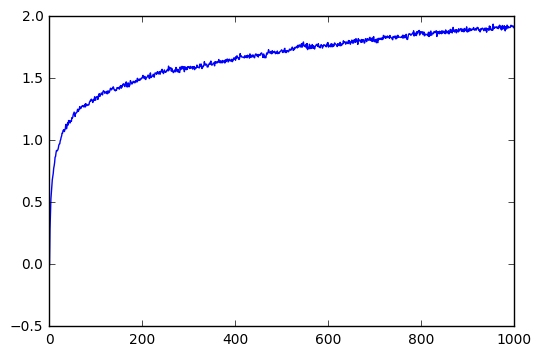

In [8]:
player = Player(100, 1000, Greedy)
player.evaluate(games=10000)